In [4]:
# Demo: NASA IMS Bearing — Anomaly Detection with Autoencoder

#This notebook demonstrates the preprocessing --> training --> evaluation pipeline results:
#- loads `features.csv` and model evaluation `recon_errors.csv`
#- inspects example raw/downsampled signals
#- visualizes reconstruction-based anomaly score
#- computes a threshold based on training period and highlights probable failure region

#If you do not have Jupyter locally, see the bottom of the notebook for instructions to run this as a script or in Google Colab.

In [7]:
# imports and user configuration
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# configure paths (adjust these if your repo layout differs)
PROCESSED_ROOT = Path("../data/processed")    # processed data root in repo
TEST_FOLDER = "3rd_test"                   # adjust to your processed folder name
EVAL_RESULTS = Path("../eval_results")        # folder created by evaluate.py
MODEL_DIR = Path("models")
# file locations
processed_path = PROCESSED_ROOT / TEST_FOLDER
features_csv = processed_path / "features.csv"
meta_json = processed_path / "meta.json"
recon_csv = EVAL_RESULTS / "recon_errors.csv"

print("Processed path:", processed_path)
print("Features file exists:", features_csv.exists())
print("Meta file exists:", meta_json.exists())
print("Recon errors file exists:", recon_csv.exists())


Processed path: ..\data\processed\3rd_test
Features file exists: True
Meta file exists: True
Recon errors file exists: True


In [8]:
# load files (with basic checks)
if not meta_json.exists():
    raise FileNotFoundError(f"Missing meta.json at {meta_json}. Run preprocess first.")
meta = json.loads(meta_json.read_text())

if not features_csv.exists():
    raise FileNotFoundError(f"Missing features.csv at {features_csv}.")

if not recon_csv.exists():
    raise FileNotFoundError(f"Missing recon_errors.csv at {recon_csv}. Run evaluate.py first.")

df_feat = pd.read_csv(features_csv)
df_recon = pd.read_csv(recon_csv)

print("meta:", {k: meta[k] for k in ("n_files_found","signal_length") if k in meta})
print("features shape:", df_feat.shape)
print("recon shape:", df_recon.shape)

meta: {'n_files_found': 6323, 'signal_length': 20480}
features shape: (6323, 8)
recon shape: (6323, 3)


In [9]:
# quick stats of computed features
display(df_feat.head())
display(df_feat.describe().T)

,mean,std,rms,skew,kurtosis,peak_freq_idx,file,index
0,-0.005102,0.078512,0.078678,-0.013807,1.157037,1009,2004.03.04.09.32.46,0
1,-0.002242,0.079784,0.079815,0.033420,0.890124,1009,2004.03.04.09.42.46,1
2,-0.002552,0.081042,0.081082,-0.027040,1.181861,1009,2004.03.04.09.52.46,2
3,-0.002534,0.079124,0.079165,-0.017775,0.585799,1010,2004.03.04.10.02.46,3
4,-0.002428,0.079535,0.079572,0.043572,0.834758,1010,2004.03.04.10.12.46,4


,count,mean,std,min,25%,50%,75%,max
mean,6323.0,-0.002366,0.000482,-0.009264,-0.002641,-0.002362,-0.002084,0.006270
std,6323.0,0.074127,0.006521,0.001143,0.071423,0.073136,0.075325,0.155126
rms,6323.0,0.074167,0.006517,0.001912,0.071465,0.073175,0.075364,0.155143
skew,6323.0,0.021646,0.035822,-0.222896,-0.000107,0.020659,0.042578,0.440111
kurtosis,6323.0,0.431805,0.179603,0.021378,0.313765,0.409163,0.518007,2.064086
peak_freq_idx,6323.0,1010.204808,103.606022,0.000000,1009.000000,1009.000000,1010.000000,4496.000000
index,6323.0,3161.000000,1825.437208,0.000000,1580.500000,3161.000000,4741.500000,6322.000000


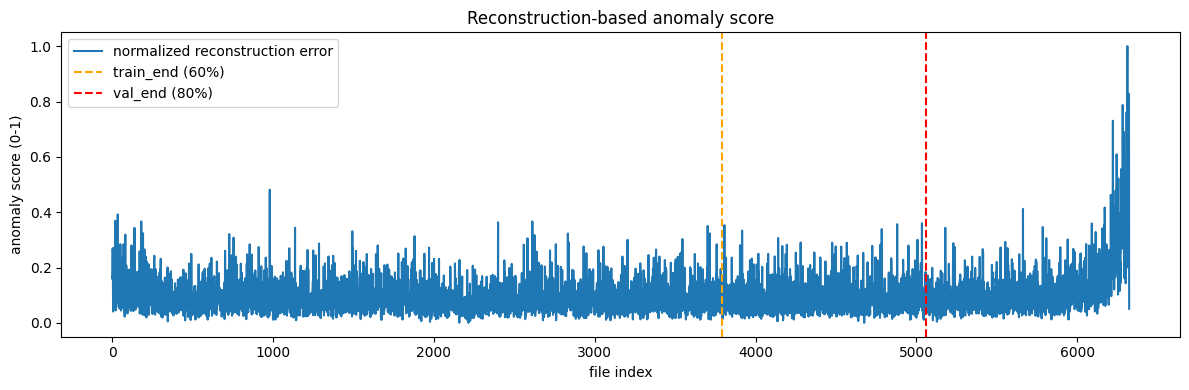

In [10]:
# plot normalized reconstruction error with train/val boundaries
n = len(df_recon)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

plt.figure(figsize=(12,4))
plt.plot(df_recon['index'], df_recon['normalized_error'], label='normalized reconstruction error')
plt.axvline(train_end, color='orange', linestyle='--', label='train_end (60%)')
plt.axvline(val_end, color='red', linestyle='--', label='val_end (80%)')
plt.xlabel('file index')
plt.ylabel('anomaly score (0-1)')
plt.title('Reconstruction-based anomaly score')
plt.legend()
plt.tight_layout()
plt.show()

Threshold (99th percentile of training): 0.272
First index exceeding threshold: 20


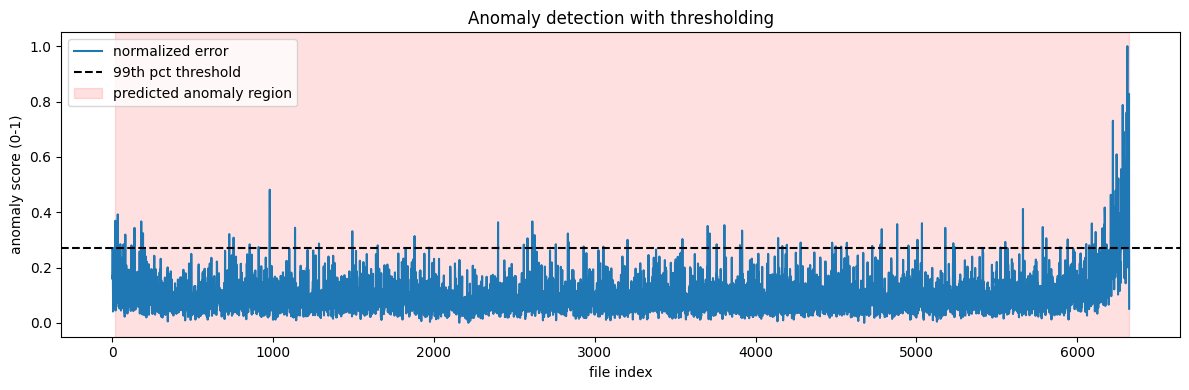

In [11]:
# automatic threshold: percentile of reconstruction error during training period
train_scores = df_recon['normalized_error'].iloc[:train_end]
threshold = np.percentile(train_scores, 99)   # 99th percentile as example
anomalous = df_recon['normalized_error'] > threshold

print(f"Threshold (99th percentile of training): {threshold:.3f}")
first_anom_idx = df_recon['index'][anomalous].min() if anomalous.any() else None
print("First index exceeding threshold:", first_anom_idx)

plt.figure(figsize=(12,4))
plt.plot(df_recon['index'], df_recon['normalized_error'], label='normalized error')
plt.axhline(threshold, color='black', linestyle='--', label=f'{99}th pct threshold')
if first_anom_idx is not None:
    plt.axvspan(first_anom_idx, n, color='red', alpha=0.12, label='predicted anomaly region')
plt.xlabel('file index')
plt.ylabel('anomaly score (0-1)')
plt.title('Anomaly detection with thresholding')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# list top anomalous indices and some feature context
topk = 10
top_idx = df_recon.sort_values('normalized_error', ascending=False).head(topk)['index'].astype(int).tolist()
print("Top anomalous file indices (highest normalized error):", top_idx)
display(df_feat.set_index('index').loc[top_idx])

Top anomalous file indices (highest normalized error): [6311, 6310, 6321, 6282, 6306, 6221, 6289, 6309, 6244, 6285]


,mean,std,rms,skew,kurtosis,peak_freq_idx,file
index,,,,,,,
6311,-0.001990,0.136937,0.136951,0.170535,0.320885,711,2004.04.18.00.52.55
6310,-0.002286,0.155126,0.155143,0.412422,0.782209,710,2004.04.18.00.42.55
6321,-0.003033,0.154452,0.154482,0.440111,1.093748,709,2004.04.18.02.32.55
6282,-0.002469,0.128971,0.128994,0.094515,0.251563,711,2004.04.17.20.02.55
6306,-0.002228,0.140589,0.140607,0.284313,1.008531,711,2004.04.18.00.02.55
6221,-0.002413,0.090863,0.090895,0.031786,0.301053,711,2004.04.17.09.52.55
6289,-0.002309,0.115599,0.115622,0.065600,0.085362,711,2004.04.17.21.12.55
6309,-0.002136,0.135537,0.135554,0.343494,0.774995,710,2004.04.18.00.32.55
6244,-0.003078,0.105078,0.105123,0.012468,0.785856,1011,2004.04.17.13.42.55


Example index: 6322


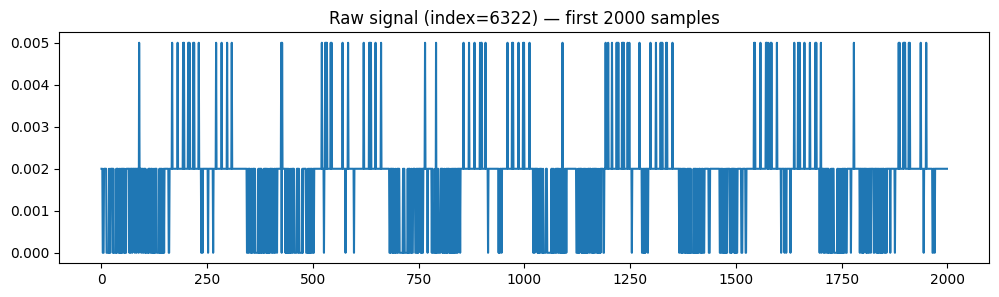

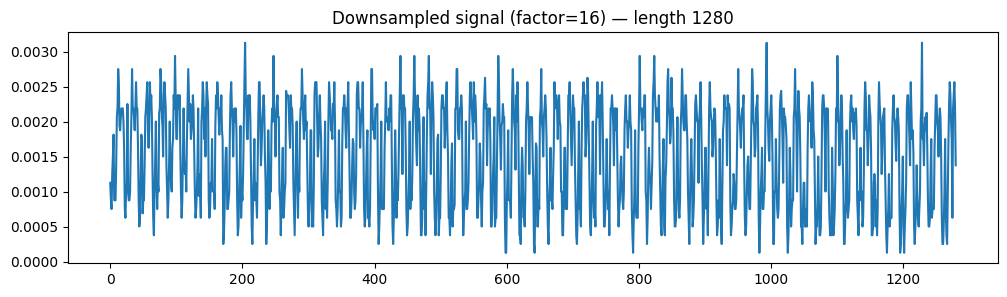

In [13]:
# If memmap/npy exists, show raw and downsampled sample signal
import matplotlib.pyplot as plt

sig_len = int(meta['signal_length'])
signals_npy = processed_path / "signals.npy"
memmap_file = processed_path / "signals_memmap.dat"

example_idx = int(df_recon['index'].iloc[-1])  # last file (likely failed)
print("Example index:", example_idx)

if signals_npy.exists():
    arr = np.load(signals_npy, mmap_mode='r')
    raw = arr[example_idx]
elif memmap_file.exists():
    n_files = int(meta['n_files_found'])
    arr = np.memmap(memmap_file, dtype='float32', mode='r', shape=(n_files, sig_len))
    raw = arr[example_idx]
else:
    raw = None

if raw is not None:
    # plot a short segment and the full downsampled version (same downsample used in training)
    downsample = 16   # match training downsample (change if different)
    down_len = sig_len // downsample
    down = raw.reshape(down_len, downsample).mean(axis=1)

    plt.figure(figsize=(12,3))
    plt.plot(raw[:2000])  # first 2000 samples for detail
    plt.title(f"Raw signal (index={example_idx}) — first 2000 samples")
    plt.show()

    plt.figure(figsize=(12,3))
    plt.plot(down)
    plt.title(f"Downsampled signal (factor={downsample}) — length {down_len}")
    plt.show()
else:
    print("No signals.npy or memmap found to visualize raw signals.")

In [14]:
## Notes and next steps

#- The threshold used above (99th percentile of training reconstruction error) is a simple heuristic.
#  You can refine detection with change-point methods, smoothing, or combining with statistical features.
#- For a clean repository demo, include `recon_error_plot.png` and `recon_errors.csv` under `eval_results/`.
#- To reproduce training, ensure `models/ae_best.pt` is present in the `models/` folder.
